The task completed by [Abapolov Philipp](https://vk.com/pheepa) 

![header](img/header.png)

# Phase-aware speech enchancement with Deep Complex U-Net #
For research I chose this article ["Phase-aware speech enchancement with Deep Complex U-Net"](https://openreview.net/pdf?id=SkeRTsAcYm), which describes the architecture and training of a convolutional neural network for improving speech, so-called denoising, and set up an experiment. 
![architecture](img/dcunet.png)

## The task ##
The main task is to develop a complex variation of the architecture of the well known UNet network to eliminate unwanted noise from the audio.

## Method's features ##
Its speciality and difference from other networks, such as SegNet, for semantic segmentation (not only that) lies in Skip-Connections and that the values of both input data and all of network parameters (convolution filters, etc.) are complex.

### Skip-Connections ###
The main idea is that the early layers of the Encoder are concatenated with the " parallel " layers of the Decoder.

![skip-connection](img/skip-connection.png)

### Mask ###
As a result of the convolution layers, we get a mask, which we multiply by the input time-frequency signal with noise and get a cleared time-frequency signal, which then passes the inverse Short-time Fourier transform.
![arch](img/arch.png) 


### Alternative solution ###
* [Improved Speech Enhancement with the Wave-U-Net](https://arxiv.org/abs/1811.11307)

## The Experiment ##
For training we will use [Noisy speech database for training speech enhancement algorithms and TTS models](https://datashare.is.ed.ac.uk/handle/10283/2791), which contains a data set for training and testing with 28 and 56 speakers in .wav audio files are 48 KHz. The 10-layer network architecture will be implemented, which looks like this:
![10-layers](img/layers.png)

A graph of changes in the value of the loss function during training and validation will be shown. 

The PESQ metric will also be calculated.

### Issues ###
Due to my lack of equipment with proper GPU (a laptop with 2 GB of GPU, so the model does not fit into the given memory, not to mention training) I had to consider alternatives for training:

* Training on Google Colab or another cloud service. 
Cloud services have strict session time limits, so it was decided to train on a small number of epochs. 

## Import of libraries

In [ ]:
import time
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchaudio
import copy

from pypesq import pesq
from matplotlib import colors, pyplot as plt
%matplotlib inline

# not everything is smooth in sklearn, to conveniently output images in colab
# we will ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from IPython.display import clear_output

Checking whether the GPU is available

In [3]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

Training on GPU.


In [4]:
!nvidia-smi

Sun Jun 14 15:10:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading and creating dataset objects #

### Loading ###

In [ ]:
!wget https://datashare.is.ed.ac.uk/bitstream/handle/10283/2791/clean_trainset_28spk_wav.zip?sequence=2&isAllowed=y
!wget https://datashare.is.ed.ac.uk/bitstream/handle/10283/2791/noisy_trainset_28spk_wav.zip?sequence=6&isAllowed=y

In [ ]:
!wget https://datashare.is.ed.ac.uk/bitstream/handle/10283/2791/clean_testset_wav.zip?sequence=1&isAllowed=y
!wget https://datashare.is.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip?sequence=5&isAllowed=y

In [ ]:
!unzip clean_trainset_28spk_wav.zip?sequence=2.3
!unzip noisy_trainset_28spk_wav.zip?sequence=6
!unzip clean_testset_wav.zip?sequence=1
!unzip nnoisy_testset_wav.zip?sequence=5

In [ ]:
!ls

The sampling frequency and the selected values for the Short-time Fourier transform.

In [ ]:
SAMPLE_RATE = 48000
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4

### The declaration of datasets and dataloaders ###

In [ ]:
class SpeechDataset(Dataset):
    """
    A dataset class with audio that cuts them/paddes them to a specified length, applies a Short-tome Fourier transform,
    normalizes and leads to a tensor.
    """
    def __init__(self, noisy_files, clean_files, n_fft=64, hop_length=16):
        super().__init__()
        # list of files
        self.noisy_files = sorted(noisy_files)
        self.clean_files = sorted(clean_files)
        
        # stft parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        # fixed len
        self.max_len = 165000

    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        return waveform
  
    def __getitem__(self, index):
        # load to tensors and normalization
        x_clean = self.load_sample(self.clean_files[index])
        x_noisy = self.load_sample(self.noisy_files[index])
        
        # padding/cutting
        x_clean = self._prepare_sample(x_clean)
        x_noisy = self._prepare_sample(x_noisy)
        
        # Short-time Fourier transform
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        
        return x_noisy_stft, x_clean_stft
        
    def _prepare_sample(self, waveform):
        waveform = waveform.numpy()
        current_len = waveform.shape[1]
        
        output = np.zeros((1, self.max_len), dtype='float32')
        output[0, -current_len:] = waveform[0, :self.max_len]
        output = torch.from_numpy(output)
        
        return output

In [ ]:
TRAIN_NOISY_DIR = Path('noisy_trainset_28spk_wav')
TRAIN_CLEAN_DIR = Path('clean_trainset_28spk_wav')

TEST_NOISY_DIR = Path('noisy_testset_wav')
TEST_CLEAN_DIR = Path('clean_testset_wav')

In [ ]:
train_noisy_files = sorted(list(TRAIN_NOISY_DIR.rglob('*.wav')))
train_clean_files = sorted(list(TRAIN_CLEAN_DIR.rglob('*.wav')))

test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))

In [ ]:
test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
train_dataset = SpeechDataset(train_noisy_files, train_clean_files, N_FFT, HOP_LENGTH)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# Declaring the class layers #

In [ ]:
class CConv2d(nn.Module):
    """
    Class of complex valued convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output

In [ ]:
class CConvTranspose2d(nn.Module):
    """
      Class of complex valued dilation convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output

In [ ]:
class CBatchNorm2d(nn.Module):
    """
    Class of complex valued batch normalization layer
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output

In [ ]:
class Encoder(nn.Module):
    """
    Class of upsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted

In [ ]:
class Decoder(nn.Module):
    """
    Class of downsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

10-layer model

In [ ]:
class DCUnet10(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        # downsampling/encoding
        self.downsample0 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45)
        self.downsample1 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=45, out_channels=90)
        self.downsample2 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample3 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample4 = Encoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        
        # upsampling/decoding
        self.upsample0 = Decoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        self.upsample1 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90)
        self.upsample2 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90)
        self.upsample3 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=180, out_channels=45)
        self.upsample4 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=90, output_padding=(0,1),
                                 out_channels=1, last_layer=True)
        
        
    def forward(self, x, is_istft=True):
        # downsampling/encoding
        d0 = self.downsample0(x)
        d1 = self.downsample1(d0) 
        d2 = self.downsample2(d1)        
        d3 = self.downsample3(d2)        
        d4 = self.downsample4(d3)
        
        # upsampling/decoding 
        u0 = self.upsample0(d4)
        # skip-connection
        c0 = torch.cat((u0, d3), dim=1)
        
        u1 = self.upsample1(c0)
        c1 = torch.cat((u1, d2), dim=1)
        
        u2 = self.upsample2(c1)
        c2 = torch.cat((u2, d1), dim=1)
        
        u3 = self.upsample3(c2)
        c3 = torch.cat((u3, d0), dim=1)
        
        u4 = self.upsample4(c3)
        
        # u4 - the mask
        output = u4 * x
        if is_istft:
            output = torch.squeeze(output, 1)
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True)
        
        return output

## Loss function ##

In [ ]:
def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
    # to time-domain waveform
    y_true_ = torch.squeeze(y_true_, 1)
    x_ = torch.squeeze(x_, 1)
    y_true = torch.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
    x = torch.istft(x_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))

    # true and estimated noise
    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)

Description of the training of epochs.

In [ ]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for noisy_x, clean_x in train_loader:

        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

        # zero  gradients
        net.zero_grad()

        # get the output from the model
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1

    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

Description of the validation of epochs.

In [ ]:
def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    
    return test_ep_loss

To understand whether the network is being trained or not, we will output a train and test loss.

In [ ]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        # first evaluating for comparison
        if e == 0:
            with torch.no_grad():
                test_loss = test_epoch(net, test_loader, loss_fn)
                
            test_losses.append(test_loss)
            print("Loss before training:{:.6f}".format(test_loss))
          

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        scheduler.step()
        with torch.no_grad():
          test_loss = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
    return train_losses, test_losses

## Metrics ##

In [ ]:
def pesq_score(net, test_loader):
    net.eval()
    test_pesq = 0.
    counter = 0.


    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x = noisy_x.to(DEVICE)
        with torch.no_grad():
            pred_x = net(noisy_x)
        clean_x = torch.squeeze(clean_x, 1)
        clean_x = torch.istft(clean_x, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
        
        
        psq = 0.
        for i in range(len(clean_x)):
            clean_x_16 = torchaudio.transforms.Resample(48000, 16000)(clean_x[i, 0,:].view(1,-1))
            pred_x_16 = torchaudio.transforms.Resample(48000, 16000)(pred_x[i, 0,:].view(1,-1))

            clean_x_16 = clean_x_16.cpu().cpu().numpy()
            pred_x_16 = pred_x_16.detach().cpu().numpy()
            
            
            
            psq += pesq(clean_x_16.flatten(), pred_x_16.flatten(), 16000)
            
        psq /= len(clean_x)
        test_pesq += psq
        counter += 1

    test_pesq /= counter 
    return test_pesq

## Training ##

In [ ]:
# clear cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
dcunet10 = DCUnet10(N_FFT, HOP_LENGTH).to(DEVICE)

In [ ]:
loss_fn = wsdr_fn
optimizer = torch.optim.Adam(dcunet10.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [94]:
train_losses, test_losses = train(dcunet10, train_loader, test_loader, loss_fn, optimizer, scheduler, 3)






  0%|          | 0/3 [00:00<?, ?it/s]

Loss before training:0.517480







 33%|███▎      | 1/3 [22:23<44:47, 1343.54s/it]

Epoch: 1/3... Loss: -0.923392... Test Loss: -0.976580







 67%|██████▋   | 2/3 [44:25<22:17, 1337.15s/it]

Epoch: 2/3... Loss: -0.944345... Test Loss: -0.976268







100%|██████████| 3/3 [1:06:28<00:00, 1329.46s/it]

Epoch: 3/3... Loss: -0.946829... Test Loss: -0.976848


## Saving ##

In [ ]:
torch.save(dcunet10.state_dict(), '__weights.pth')

## PESQ метрика ##
Let's calculate the average value of the metric in the test sample.

In [ ]:
pesq_metric = pesq_score(dcunet10, test_loader)

# The Results #

## Loss ##
Let's look at the graph of loss reduction for 3 epochs on the test, the loss for the first epoch decreases very quickly.

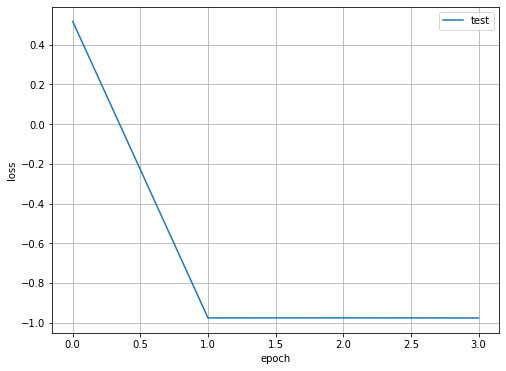

In [152]:
f = plt.figure(figsize=(8, 6))
plt.grid()
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [150]:
print("Min test loss: {:.6f}, min train loss: {:.6f}".format(min(test_losses), min(train_losses)))

Min test loss: -0.976848, min train loss: -0.946829


We managed to achieve a great loss, taking into account that the values lie on the segment [-1, 1].

## PESQ metrics ##

In [153]:
print("Value of PESQ: {:.6f}".format(pesq_metric))

Value of PESQ: 2.818076


Values of the PESQ metric calculated on different networks from the article: 

![pesq](img/metric.png)

Taking into account the fact that our 10-layer model was trained for only 2 epochs, we have achieved decent results. Our moel even shows a greater metric value than Wiener, SALON, MEGAN. 

## Visualization ##
Let's take a look at the time-domain waveform of a pure signal, with noise and predicted :


In [ ]:
dcunet10.eval()
x_n, x_c = iter(test_loader).next()
x_est = dcunet10(x_n.cuda(), is_istft=True)

Purified

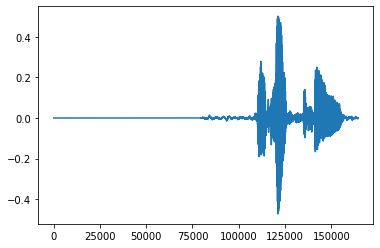

In [151]:
plt.plot(x_est[1].view(-1).detach().cpu().numpy())

Clear

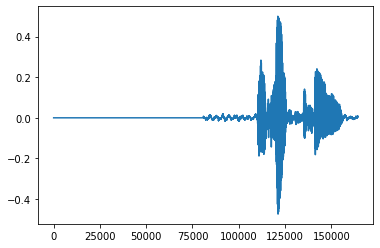

In [152]:
x_c[1] = torch.squeeze(x_c[1], 1)
plt.plot(torch.istft(x_c[1], n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())

With Noise

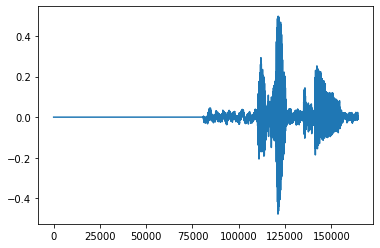

In [153]:
x_n[1] = torch.squeeze(x_n[1], 1)
plt.plot(torch.istft(x_n[1], n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True).view(-1).detach().cpu().numpy())

In General, it can be seen that the cleared signal is close to the purified one.

## Conclusions ##

We conducted an experiment: we implemented the Deep Complex UNet architecture, trained it, and tested it.

The obtained minimum loss value on validation: -0.976848
The resulting PESQ metric value: 2.818076

The value of the PESQ metric on a 20-layer network from the article: 3.24

We were able to get close enough to the results of the study described in [the article](https://openreview.net/pdf?id=SkeRTsAcYm). But the values still turned out a little worse for the following reasons

1.The possile minimum size of network: 10 layers instead of 20.

2. A small number of epochs. 3 epochs is too little, but the results are enough for us.


## The prospects ##
* You can implement a deeper variation of Deep Complex U-Net using the same principle
* The use of more powerful in terms of computing hardware(more memory) and increase the size of the batch to increase the speed of learning
*Training on a larger number of epochs.
* Augmentation of a dataset to increase its size by adding synthetic noise

## In practice ##
This technology can be used to improve the sound of phone calls, in the same voice messages in messengers and social networks, for professional video and audio processing.  